In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

This is a document that was meant to record some experiments with policy gradients which is a class of reinforcement learning techniques. My goal was to get better intuition and hopefully I'll transfer more results here over a few days. I am also adding some notes that will hopefully make it useful as a tutorial.

Maybe this should be a latex doc with embedded code, maybe it should be a notebook, maybe it should be a video. I can't decide which one would aid understanding the most, so here is one option that might work well.

## Drive-by View

Suppose, we want a computer to learn the steps to successfully achieve a task. Instead of explicitly programming the computer, we want it to figure a program out on its own. By program here, we don't necessarily mean the actual source code in a language. While we as humans use programming languages to express ideas, it's fruitful to deal directly with mathematics when a computer is learning on its own.

It helps to have a few examples when dealing with a new subject. Imagine the following:

* playing a game - chess, age of empires, pong etc. 

* debugging code

* navigating a robot in a room

* sorting an array

The fourth one is one where we have very efficient algorithms that we can implement directly in a language of our choice. The other three are not so simple. We don't have specific rules or algorithms that we can follow to carry them out. We can try and codify what we would do in those situations but that often leads to catastrophic edge cases and algorithms that don't react well in unknown situations. At this stage, we'll abstract out the core properties of these problems.

## A Closer Drive-by View

One can view all these problems as decision-making processes. How do we make decision in real life?

* We assess a situation

* We use what we know to decide on and carry out a decision

* We observe a signal that tells us whether what we did was fruitful or not

* Repeat

Real life is messy but maybe we could treat all decision-making problems by the above framework. At the same time, we need to make them more precise.

**"We assess a situation"**:

What does this mean? In the case of a game, we stare at a board or a computer screen and observe the current situation or state of the game. Our observation, whether described in words or mathematical symbols or pictures, describes everything going on at this moment in time. We usually call this description the **state** of the system we are observing. It is a mathematical object called a **vector** (sorry if this is too pedantic) which you can think of as a collection of $n$ numbers.

**"We use what we know to decide on and carry out a decision"**

We observe the state and make a decision. This process can be encoded as a function that takes in the current as well as past states as an input and outputs the probabilities of all the possible **actions** (if finite). We then choose one of these decisions.

This is, of course, easier said than done. After all, this is like describing debugging as: look at the code and fix it. While technically true, depending on the code base, this is a hard task! What also makes it harder is that we need to take into account not just the state now but at all times in the past. 

We usually have a statistical model (a neural network, linear regression, a random forest) that maps the states (and their history) to the probabilities for each action. This model is called the **policy**.

**"We observe a signal that tells us whether what we did was fruitful or not"**

This is tricky. When you are playing chess and you make a move, sometimes it's obvious that it was a great move or a very bad move. But mostly, it's not that obvious. After all, there's no way to judge a move except for the eventual outcome of winning or losing.

A lot of reinforcement learning problems model a **reward** at every time-step i.e. for each action. This is highly dependent on the problem and often there can be multiple choices. For example, in the chess example, you might assign a reward of +1 if you capture your opponent's piece, -1 if your opponent captures your piece and 0 otherwise (can you think of issues with this definition if you are a chess player?).

In any case, once we have a reward at every time-step, our task is not to maximize this reward. Instead we want to maximize the sum of rewards across **all** time-steps! This is a very crucial point and is what injects the notion of long-term planning into such problems. It is usually easy to do something that maximizes current reward. But that often doesn't lead to long-term reward maximization. For example, capturing pieces greedily in Chess will maximize current reward but you'll most likely lose the game to a well-trained amateur.


So at this stage, we are starting to impose some structure on how we want to describe the problem to a computer.

We have some task. Everything connected to the task is called the **environment**. For chess, it's the chess board. For the robot, it's the robot and the room it is navigating within.

There is a vector describing the **state** of the environment. This tells us everything relevant we need to know about the environment at any point in time.

There is an **agent** that we focus on. This might be the chess player or our robot. The agent is what we control.

The agent follows a **policy** that tells it what to do in various states. "What to do" refers to **actions** that can be taken.

The eventual goal is to find a policy that maximizes not just the immediate reward for the agent but the long-term total sum of rewards across all time.



## An Even Closer Drive-by View

Consider an abstract, arbitrary state space $\mathcal{S}$. This can be discrete or continuous and can be high-dimensional too. As a different reference example, think of an ant's position on a two-dimensional plane, $\mathbb{R}^2$.

We always start our task at some starting point, $s_0 \in \mathcal{S}$. This can be a fixed point or can be drawn from a distribution $\rho(s)$.

We have a task or goal to achieve. This is modelled as a reward-maximization task. The goal is to take steps or actions from an action space, $\mathcal{A}$ that lead us to follow trajectories or paths that maximize some (to be made precise below) overall reward. In our example, the goal might be to go from a starting point to and end point in the shortest possible time. This can be rephrased as a maximization problem instead of a minimization problem by the usual identification $\max_x f(x) = \min_x (-f(x))$ (if this is not clear, draw a diagram of an arbitrary function and see what both sides mean geometrically).

Our first key observation is that we keep referring to "current time-step". Time is continuous not discrete! But realistically, all our computing systems treat time as a discrete quantity. It might be a very fine-grained discretization but it is discrete nonetheless and hence, it makes sense to talk about "time-steps".

So, we have time ticking along at a regular rate (not how the universe works but unless we are working with relativistic objects, it's a very good approximation). At each step, we observe the state of our environment, pick an action recommended by the policy, get an immediate reward and observe the next state. This loop repeats either indefinitely or till a natural stopping point in time. This gives us a sequence:

$$s_1 \rightarrow a_1 \rightarrow r_1 \rightarrow s_2 \rightarrow a_2 \rightarrow r_2 \rightarrow \ldots $$

or for arbitrary time,

$$\ldots \rightarrow s_t \rightarrow a_t \rightarrow r_t \rightarrow \ldots $$

Our goal is to maximize the total reward:

$$R = r_1 + r_2 + r_3 + \ldots + r_t + \ldots$$

**Pedantic Note**:

This is usually condensed using a capital-Sigma (Greek "S" letter, "S" for sum) to:

$$R = \Sigma_{t=1}^{T} r_t$$

where $T$ is when the experiment ends or can be $\infty$ if the experiment never ends. Often, it is onerous to carry around the index and it is suppressed:

$$R = \Sigma_t r_t = \Sigma r_t$$

**End of Pedantic Note**

To make this more transparent, the only thing **we** (the agent and the policy running the agent) control in the sequence:

$$\ldots \rightarrow s_t \rightarrow a_t \rightarrow r_t \rightarrow \ldots $$

are the actions, $a_t$. The action at a given time-step might depend on the current state, $s_t$ as well as all the historical states, $s_1, s_2, \ldots, s_{t-1}$. Here is where we make our second assumption. We will only, in theory at least, deal with so-called **Markov** systems. What does this mean?

While defining a Markov system is simple, let's look at some context.


## A Super-Close Look



## Finer Points

gamma
time
state space
action space
reward structure
MDPs

# Policy Gradients

While we discussed reinforcement learning, we didn't discuss how we would actual find the optimal policy, $\pi(a_t|s_t, \theta)$. **Policy gradient methods** describe a general set of techniques to directly change the policy to maximize the expected (more on this) reward.

Suppose, we consider the space of all trajectories:

$$\tau \equiv s_1 \rightarrow a_1 \rightarrow r_1 \rightarrow s_2 \rightarrow a_2 \rightarrow r_2 \rightarrow \ldots $$

In principle, we could run across every single one of these and always pick the one that maximizes the total reward for each trajectory. Of course, this is prohibitive because (1) even if the state and action spaces are discrete, the number of trajectories is huge!, (2) since our actions are stochastic, we can't actually guarantee that a certain action will lead to a certain state.

What do we do instead? Each trajectory has a certain total reward associated with it. Every time we run with a certain policy i.e. use a policy to choose the actions $a_t$, we get one sample trajectory. We can't guarantee that there is a best or optimal policy that always puts us on the trajectory with the maximum reward but we can try aiming to get the maximal average (or expected) reward. As an analogy, if you are a world-class tennis player, we can't guarantee a training regime that will ensure you win every game you ever play. There is some randomness to that process (you have a bad day, you are injured etc.) but we can at least aim to ensure that on average your likelihood to win is as high as possible.

In mathematical terms, the average or expected total reward is given by:

$$J \equiv \Sigma_{\tau} R(\tau) P(\tau; \theta)$$

**Pedantic Aside**:

An average or mean of n numbers is simply:

$$\bar{x} = \frac{x_1 + \ldots + x_n}{n}$$

Imagine we have k distinct values, $x_1, x_2, \ldots, x_k$ each occuring $n_1, n_2, \ldots, n_k$ times. We have $n_1 + \ldots + n_k = n$.

We can rewrite the average as:

$$\bar{x} = \frac{x_1 n_1 + x_2 n_2 + \ldots + x_k n_k}{n} = x_1 p_1 + \ldots + x_k p_k$$

where $p_i = \frac{n_i}{n}$ is the probability of getting a measurement, $x_i$. The continuous version of this is:

$\bar{x} = \int dx x p(x)$

where $p(x)$ is a probability distribution function (p.d.f.) i.e. $p(x) \geq 0$ and $\int dx p(x) = 1$.

Lastly, the average or expected value of a function of the inputs would be:

$$\bar{f(X)} = \mathbb{E}f(X) \equiv \Sigma_{x} f(x)p(x)$$

where $\mathbb{E}$ denotes the expected value. In this notation, we have

$$J = \mathbb{E}R = \Sigma_{\tau} R(\tau) P(\tau; \theta)$$

**End of aside**

This equation packs a lot of meaning so let's decode that. We are summing over all trajectories, $\tau$. That is computationally infeasible but that's not relevant right now. $R(\tau)$ denotes the total reward for some trajectory:

$$\tau \equiv s_1 \rightarrow a_1 \rightarrow r_1 \rightarrow s_2 \rightarrow a_2 \rightarrow r_2 \rightarrow \ldots $$

$$\implies R(\tau) = r_1 + r_2 + r_3 + \ldots$$

$P(\tau; \theta)$ denotes the total probability of a trajectory. This is where the Markov property is very useful. Because each time-step depends only on the previous one, we can treat different times as independent and write:

$$P(\tau) = \underbrace{{\rho(s_1)}}_{\text{initial dist.}} \underbrace{\pi(a_1|s_1)}_{\text{policy}}\underbrace{\rho(s_2|s_1,a_1)}_{\text{dynamics}} \underbrace{\pi(a_2|s_2)}_{\text{policy}} \underbrace{\rho(s_3|s_2,a_2)}_{\text{dynamics}}\ldots$$

Each term above is a probability. The policy tells us the probabilities of taking various actions. Dynamics are something intrinsic to the system. $\rho(s_t|s_{t-1},a_{t-1})$ describes how a system evolves in time or how its state changes with time. This is exactly what a lot of physics is all about. We want to discover how planets will orbit with time or how a hydrogen atom will behave over time. If something is known about the dynamics of our environment, we can and maybe even should (depending on how complex it is) exploit it. But we will generally assume that nothing is known about the dynamics a priori.

We want to maximize, $J = \Sigma_{\tau} R(\tau) P(\tau; \theta)$ but (1) we can't sum over all trajectories and (2) we don't know the initial distribution $\rho(s_1)$ as well as the dynamics $\rho(s_t|s_{t-1}, a_{t-1})$. So how we do make progress?

The first key observation is that the only thing we control is $\theta$. These are the parameters of the policy. We can't control the dynamics because they are intrinsic to the environment/system.

The second observation comes from a straightforward choice. We have a function $J(\theta)$ that we want to maximize. If we can take the first derivatives with respect to $\theta$, then we could use gradient descent.

**Aside**:

At its core, gradient descent is remarkably simple. Suppose you have a function, $f(x)$ of one variable. Also, suppose it is differentiable. Then we can see from the following picture:

INSERT PICTURE

that we should always move opposite to the direction of the derivative. If the derivative is positive, we should move in the negative direction to decrease the function. If the derivative is negative, we should move in the positive direction to decrease the function.

So, we can write an iterative algorithm where we start with some initial guess $x_0$ and then:

$$x_t = x_{t-1} - \frac{df}{dx}(x_{t-1})$$

Usually we want to control how far we move and that's done by introducing a step-size or learning rate, $\eta$.

$$x_t = x_{t-1} - \eta \frac{df}{dx}(x_{t-1})$$

Another way of stating this is to say that we are locally approximating our function as a linear function (a line) and moving along the line. The further we move away from our current point, the worse the linear approximation will get and so we want to control how far we move.

A key point here is that since we are only exploiting local information, we will most likely get stuck in a local minimum not the global minimum.

For functions that depend on many variables, $f(x_1, x_2, \ldots, x_n)$, there is a very straightforward generalization.

$$f(x_1^{t}, x_2^{t}, \ldots, x_i^{t}, \ldots, x_n^{t}) = f(x_1^{t-1}, x_2^{t-1}, \ldots, x_i^{t-1}, \ldots, x_n^{t}) - \eta \frac{\partial f}{\partial x_i}(x_1^{t-1}, x_2^{t-1}, \ldots, x_i^{t-1}\ldots, x_n^{t-1})$$

These partial derivatives form a vector called the gradient:

$$\nabla f(x_1,\ldots,x_n) = (\frac{\partial f}{\partial x_1}, \ldots, \frac{\partial f}{\partial x_n})$$

and we write gradient descent in the more compact notation:

$$\vec{x}^{t} = \vec{x}^{t-1} - \eta \nabla f(\vec{x}^{t-1})$$

Geometrically, we have some curved surface ("manifold") which we are approximation locally as a plane. The gradient vector points in the direction of maximal increase and so we move opposite the gradient by a step-size $\eta$.

**End of aside**

To use gradient descent, we need the gradient of $J$ with respect to $\theta$ (which is generally a vector i.e. we have many weights that our policy depends on).

So,

$$\nabla_{\theta} J(\theta) = \nabla \Sigma_{\tau} R(\tau) P(\tau; \theta)$$

Derivatives are linear operations i.e. $\frac{d}{dx}(f(x) + g(x)) = \frac{df}{dx} + \frac{dg}{dx}$ so the derivative of the sum is the sum of derivatives:

$$\nabla_{\theta} J(\theta) = \Sigma_{\tau} \nabla[R(\tau) P(\tau; \theta)]$$

$R(\tau)$ doesn't depend on $\theta$. Once the sequence of states and actions (which describes the trajectory) is fixed, changing $\theta$ won't change the total reward, $R(\tau)$. So,

$$\nabla_{\theta} J(\theta) = \Sigma_{\tau} R(\tau) \nabla P(\tau; \theta)$$

So far so good. Now it is generally ideal to write quantities as expected values because as we will see soon, averages can be estimated from samples which can be generated by Monte-Carlo simulations. Expected values have the structure $\mathcal{E}f(X) = \Sigma f(x) p(x)$.

We instead have $\nabla P(\tau; \theta)$. Can we write this as $P(\tau; \theta) * \text{something}$? The analog of this would be the question:

Can you write $\frac{df}{dx}$ as $f(x) * \text{something}$? Let's try this out.

Suppose, $\frac{df}{dx} = G(x) f(x)$ for some unknown $G(x)$. Then,

$$\frac{df}{f(x)} = G(x) dx$$

Integrating both sides, we get

$\log|f(x)| = \int G(x) dx$

or (using the fundamental theorem of calculus),

$$G(x) = \frac{d\log|f(x)|}{dx}$$

Of course, you could have just guessed this from above or verified it knowing that:

$$\frac{d\log f(x)}{dx} = \frac{1}{f(x)} \frac{df}{dx}$$

The same calculation holds for the gradient and we get:

$$\nabla_{\theta} J(\theta) = \Sigma_{\tau} R(\tau) \nabla [\log P(\tau; \theta)] P(\tau; \theta)$$

Now we can write this as an expectation:

$$\nabla_{\theta} J(\theta) = \mathbb{E}_{\tau} R(\tau) \log P(\tau; \theta)$$

where $\mathbb{E}_{\tau}$ makes it explicit that the average is taken over all trajectories. Why did we go through this trouble of writing our sum as an expectation? In its original form:

$$\nabla_{\theta} J(\theta) = \Sigma_{\tau} R(\tau) \nabla P(\tau; \theta)$$

it wasn't obvious at all that we could compute this. How are we supposed to get $\nabla P(\tau)$? By writing it as an expectation, we can use use the machinery of Monte-Carlo to estimate the expected value i.e. $\nabla J(\theta)$.

### Monte-Carlo Simulations

Consider the problem of computing an expected value of some quantity, $X$ following a probability distribution function (p.d.f.) $p(x)$. Mathematically, we want to compute the integral:

$$I = \int_{-\infty}^{\infty} dx p(x) f(x)$$

The problem is that we don't know $p(x)$! If we did, maybe we could do some kind of discrete approximation:

$$I \approx \Sigma_{x_i} p(x_i) f(x_i)$$

where $x_i = i * \delta$ for some fixed lattice spacing $\delta$ on the one-dimensional real line and $i$ is an integer.

But an elegant way presents itself. What if we can **sample** various values of X?! If the samples are drawn from the distribution $p(x)$ (the histogram of $n$ samples gets closer to $p(x)$ as $n$ gets larger) and we have a way of drawing more samples when we desire, then we can approximate $I$ as:

$$\hat{I} \approx \Sigma_{x\sim p} f(x_i)$$

This might be confusing if it's the first time you are seeing this so let's pick an example. Suppose you want to measure the average height of people in a country, C. This would be:

$$\bar{h} \equiv \mathbb{E}H = \int_0^{\infty} dh h p(h)$$

where $p(h)dh$ = probability that a person has height between $h$ and $h+dh$.

We don't know $p(h)$ a priori but we just sample i.e. randomly pick $n$ people from the population. As long as the sample is random, the probabilility distribution of our sample will be similar to the actual distribution $p(h)$. BETTER EXPLANATION

There are some core questions one would want to answer. (1) What is the error between the Monte-Carlo (MC) estimate, $\hat{I}$ and the actual value, $I$. We expect this error to vanish (go to 0) as the sample size $n$ increases but how fast does it vanish? (2) What is the variance of $\hat{I}$? If we picked $k$ different samples of size $n$ each, each sample would have a different estimate $\hat{I}_k$. Hopefully, on average, these $I_{k}$ will be equal to the true value, $I$ (zero bias) but what about the variance in the values $I_k$? Can we minimize that?

Monte-Carlo Methods are a beautiful and deep topic that have multiple applications. We won't go any deeper here but further study of the topic is highly recommended.

Recall, our central object of interest was:

$$\nabla_{\theta} J(\theta) = \mathbb{E}_{\tau} R(\tau) \log P(\tau; \theta)$$

If we can compute this gradient, we can use gradient ascent (not descent) to maximize $J(\theta)$. Since we wrote it as an expectation, we might be able to use Monte-Carlo sampling which doesn't require the explicit knowledge of the underlying probability distribution to generate $n$ trajectories (also known as **rollouts**) from our policy and then estimate $\nabla_{\theta} J(\theta)$. But we still have a problem. Unlike the simple MC example given above where $f(x_i)$ didn't depend on $p(x)$, here $f(X) = R(\tau) \log P(\tau; \theta)$ i.e. it depends on $p(x)$. So maybe we are really stuck. We don't know $P(\tau)$ and need it to estimate the gradient even by MC methods.

Let's look at $\log P(\tau)$ in more detail. Recall:

$$P(\tau) = \underbrace{{\rho(s_1)}}_{\text{initial dist.}} \underbrace{\pi(a_1|s_1)}_{\text{policy}}\underbrace{\rho(s_2|s_1,a_1)}_{\text{dynamics}} \underbrace{\pi(a_2|s_2)}_{\text{policy}} \underbrace{\rho(s_3|s_2,a_2)}_{\text{dynamics}}\ldots$$

Logs have the nice property of mapping products to sums i.e.: $\log(ab) = \log(a) + \log(b)$.

$$\log P(\tau) = \log\rho(s_1)+ \log \pi(a_1|s_1) + \log\rho(s_2|s_1,a_1) + \log\pi(a_2|s_2) + \log\rho(s_r|s_2,a_1) + \ldots$$

Note that the only terms that depend on $\theta$ are the ones with the policy, $\pi$! The derivatives with respect to $\theta$ for the other terms are 0! So,

$$\nabla_{\theta}\log P(\tau) = \nabla_{\theta}\log\rho(s_1)+ \nabla_{\theta}\log \pi(a_1|s_1) + \nabla_{\theta}\log\rho(s_2|s_1,a_1) + \nabla_{\theta}\log\pi(a_2|s_2) + \nabla_{\theta}\log\rho(s_r|s_2,a_1) + \ldots$$

$$\implies \nabla_{\theta}\log P(\tau) = \nabla_{\theta}\log \pi(a_1|s_1) + \nabla_{\theta}\log\pi(a_2|s_2) + \ldots$$

I am not using $\Sigma$ explicitly to keep the notation out of the way in case the reader is just getting familiar with it. This is usually written as:

$$\implies \nabla_{\theta}\log P(\tau) = \Sigma_{i=1}^{T}\nabla_{\theta}\log \pi(a_i|s_i)$$

This is a key breakthrough. The structure of $P(\tau)$ depended on the initial distribution of states, $\rho(s)$ as well as on the dynamics, $\rho(s_t|s_{t-1},a_{t-1})$ which are both generally unknown. It would be a tall order to find out the exact dynamics of an arbitrary environment. Maybe we could empirically approximate it by doing many experiments. But what we found is that we actually don't need dynamics to compute the gradient needed for gradient ascent. All we need is the policy which is completely under our control.

Now we have:

$$\nabla_{\theta} J(\theta) = \mathbb{E}_{\tau} R(\tau) \log P(\tau; \theta) = \mathbb{E}_{\tau} R(\tau) \left(\Sigma_{t=1}^{T} \log \pi(a_t|s_t)\right) = \boxed{\mathbb{E}_{\tau} \left(\Sigma_{t=1}^{T} r_t\right) \left(\Sigma_{t=1}^{T} \log \pi(a_t|s_t)\right)}$$

where we used $R(\tau) = r_1 + r_2 + \ldots + r_T = \Sigma_{t=1}^T r_t$.

At this stage, we can use Monte-Carlo to estimate this expected value. Just like we estimated the average height, $\mathbb{E}H \approx \frac{h_1 + \ldots + h_n}{n}$ by sampling $n$ random people, we can estimate $\nabla_{\theta} J(\theta) = \mathbb{E}_{\tau} \left(\Sigma_{t=1}^{T} r_t\right) \left(\Sigma_{t=1}^{T} \log \pi(a_t|s_t)\right)$ by sampling $n$ random *trajectories* using actions taken from our policy. In other words,

$$\nabla_{\theta} J(\theta) \approx \frac{1}{n}\Sigma_{i=1}^{n} \left(\Sigma_{t=1}^{T} r_t^{(i)}\right) \left(\Sigma_{t=1}^{T} \log \pi(a_t^{(i)}|s_t^{(i)})\right)$$

The index $i$ runs over the $n$ sampled trajectories. There is a superscript on each state and action indicating which trajectory it comes from. If this is too confusing, consider one trajectory. We can start in a start state (either fixed or from a chosen distribution). Our current policy (with parameters $\theta$) gives us the probability distribution on the possible actions one can take from the current state. We sample one of these actions which "takes us to a new state" (more on this in a moment) and gives us an immediate reward, $r_1$. We can again use our policy to sample an action and repeat this process for time-period $T$. This is one sampled trajectory.

We can compute the total reward for this trajectory from the $r_t$. Since we know what actions we took and since we know the probabilities of taking those actions from our policy, we can compute $\log \pi_{\theta}(a_t|s_{t-1})$ and thus the derivatives of this with respect to $\theta$: $\nabla_{\theta}\log \pi_{\theta}(a_t|s_{t-1})$. Repeating this for each time-step gives us the quantity: $\left(\Sigma_{t=1}^T r_t\right)\left(\Sigma_{t=1}^T \nabla_{\theta}\log\pi(a_t|s_t)\right)$

We can do this for $n$ trajectories, average these products of sums, and get an estimate of $\nabla_{\theta} J(\theta)$. This would be used to update our policy:

$$\theta_{t+1} = \theta_{t} + \eta \nabla_{\theta} J(\theta)$$

where $\theta_{1}$ is the set of parameters for the initial policy, which is updated through time.

Above, we mentioned that taking an action "takes us to a new state". Recall that the new state depends on the dynamics, $\rho(s_t|s_{t-1},a_{t-1})$ which we usually don't know! So how do we know which state to go to? We usually do these experiments either in real-life or a simulator. In real-life, the dynamics are of course, "built in". An accurate simulator will mimic real-life closely but with the advantage that one has the ability to morph and change the environment as well as look at information not available to the policy but that might help understand the agent's behavior.


# Experiment 1: Number Matching

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pylab as plt

To test out these ideas, we need to start with simple experiments. Let's start with a simple state space - it is (1) discrete, (2) one-dimensional, (3) small i.e. has only a few states. We consider all integers from some limit -N to +N (inclusive of end points) to form our state space.

In [21]:
def create_state_action_space(N):
    space = torch.arange(-N,N+1).float()
    
    return space

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])


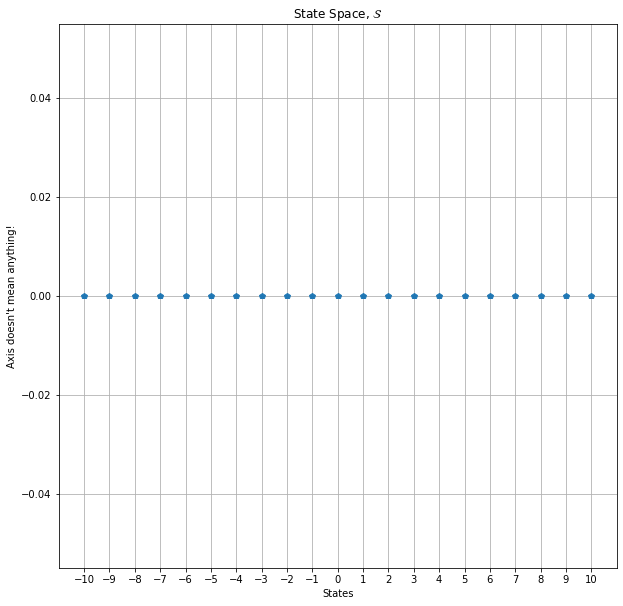

In [22]:
space = create_state_action_space(10)
print(space)

plt.figure(figsize=(10,10))
plt.plot(space, [0]*len(space), 'p')
plt.title('State Space, $\mathcal{S}$')
plt.xlabel('States')
plt.ylabel("Axis doesn't mean anything!")
_ = plt.xticks(space)
plt.grid()

We also need an action space. Well, let's pick it to have the same values (you'll see why) as the state space. Mathematically, the action space $\mathcal{A}$ is completely separate from the state space, $\mathcal{S}$ but in our case, we'll use the same function above to create the action space.

In [27]:
xtorch.matmul(space, space.T)

tensor(770.)

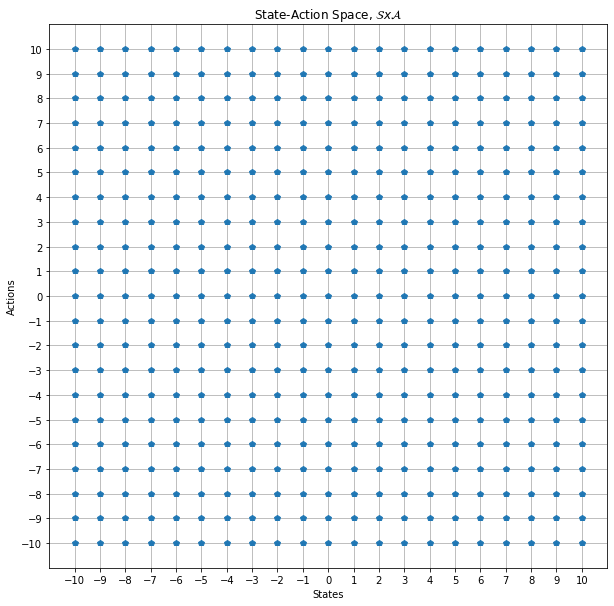

In [62]:
xes, yes = torch.meshgrid(space, space)

plt.figure(figsize=(10,10))
plt.plot(xes.flatten(), yes.flatten(), 'p')

plt.title('State-Action Space, $\mathcal{S} x \mathcal{A}$')
plt.xlabel('States')
plt.ylabel("Actions")

_ = plt.xticks(space)
_ = plt.yticks(space)
plt.grid()

Every point in the figure above denotes a **state-action** pair: $(s,a)$. The action space happens to look the same as the state space but that's generally not the case.

To define the environment and the task further, we need a **reward** function. In our case, this is a function of the state and action:

$$r(s,a)$$

We will define this as follows:

$$r(s,a) = -(s-a)^2$$

Your overwhelming question should be why this reward? Recall that we are trying to construct a toy example to try policy gradients. The state and action space were chosen to be the same. What this reward function says is that the immediate reward will be high when $s=a$ and decreases (becomes more negative) as $a$ differs more from $s$.

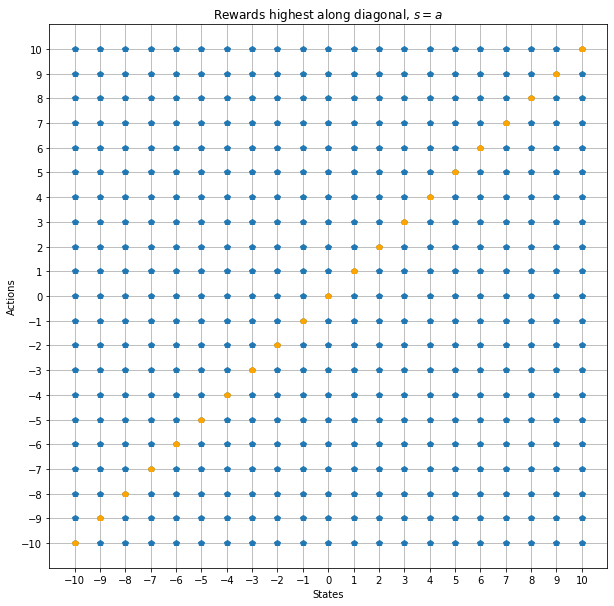

In [75]:
xes, yes = torch.meshgrid(space, space)

plt.figure(figsize=(10,10))
plt.plot(xes.flatten(), yes.flatten(), 'p')
plt.plot(space, space, 'p', color='orange')

plt.title('Rewards highest along diagonal, $s=a$')
plt.xlabel('States')
plt.ylabel("Actions")

_ = plt.xticks(space)
_ = plt.yticks(space)
plt.grid()

The only thing missing from our example is the dynamics which is defined below.

ADD NOTE about simple dynamics and greedy maximization

In [77]:
def select_start_state(state_space):
    '''Choose a start state uniformly randomly from state space
    '''
    state = state_space[torch.multinomial(torch.ones(len(state_space)), 1)]

    return state

#some useful state parameters
N_space = len(space)
low_state = torch.min(space).unsqueeze(0).unsqueeze(0)
high_state = torch.max(space).unsqueeze(0).unsqueeze(0)

def dynamics(state, action, step_size, space):
    '''Simple dynamics
    '''
    if not isinstance(step_size, int) or step_size <= 0:
        raise ValueError("step_size should be a positive integer")

    #move left/right depending on action
    #space was chosen to have negative values so action could be both positive (right moves)
    #or negatives (left moves)
    new_state = state + step_size*action

    #hard boundary conditions - if hit boundary, stay there
    if new_state > high_state:
        new_state = high_state
    if new_state < low_state:
        new_state = low_state

    #periodic boundary conditions
    #new_state = low_state + (new_state + low_state) % N_space

    return new_state

def reward(state, action):
    return -torch.pow((state - action), 2)

We also need to define out policy, $\pi(a_t|s_t)$. This can be any differentiable model but we'll choose a neural network here. N_inputs is the dimensionality of the state space and N_outputs is the number of distinct (discrete, in our case) actions.

In [78]:
class PolicyNet(nn.Module):
    def __init__(self, N_inputs, N_outputs, N_hidden_layers, N_hidden_nodes, activation, output_activation):
        super(PolicyNet, self).__init__()
        
        self.N_inputs = N_inputs
        self.N_outputs = N_outputs
        
        self.N_hidden_layers = N_hidden_layers
        self.N_hidden_nodes = N_hidden_nodes
        
        self.layer_list = nn.ModuleList([]) #use just as a python list
        for n in range(N_hidden_layers):
            if n==0:
                self.layer_list.append(nn.Linear(N_inputs, N_hidden_nodes))
            else:
                self.layer_list.append(nn.Linear(N_hidden_nodes, N_hidden_nodes))
        
        self.output_layer = nn.Linear(N_hidden_nodes, N_outputs)
        
        self.activation = activation
        self.output_activation = output_activation
        
    def forward(self, inp):
        out = inp
        for layer in self.layer_list:
            out = layer(out)
            out = self.activation(out)
            
        out = self.output_layer(out)
        if self.output_activation is not None:
            pred = self.output_activation(out)
        else:
            pred = out
        
        return pred

We are ready to start generating trajectories or paths! The process is very simple. We select a starting state (either deterministically or randomly), use our policy to generate a probability distribution on the actions, sample an action (either pick the one with maximum probability or sample according to the distribution), get an immediate reward and use the dynamics to jump to a new state. This process is repeated on the new state till some termination criterion. In our case, we run each trajectory for $T$ time-steps.

In [125]:
def create_trajectories(N, T, policy, step_size, space, debug=False):
    traj_action_probs = []
    traj_rewards = []
    traj_total_rewards = []

    for i in range(N): #loop over trajectories
        
        #select initial state for trajectory
        state = select_start_state(space).unsqueeze(0)
        
        #needed quantities
        action_probs_list = [] #log probability of each action taken
        reward_list = [] #each immediate reward received
        total_reward = 0 #total reward

        if debug:
            print(f'Starting State: {state}')
        
        for t in range(T): #loop over time-steps within a trajectory
            
            #use policy to compute probability distribution on action space
            action_probs = policy(state).squeeze(0)
            
            assert((action_probs.sum().item()-1)**2 < 0.001)
            
            #select one of the actions according to the probability distribution
            action_selected_index = torch.multinomial(action_probs, 1) #index in action list
            action_selected_prob = action_probs[action_selected_index] #probability value
            action_selected = space[action_selected_index] #action selected (in our action space)
            
            if debug:
                print(f'---------Time step: {t}---------')
                print(f'Action probabilities: {action_probs}')
                print(f'Sum of Action probabilities: {action_probs.sum().item()}')
                print(f'Action selected index: {action_selected_index}')
                print(f'Action selected prob : {action_selected_prob}')
                print(f'Action selected      : {action_selected}')

            #record action prob (needed for computing gradients)
            action_probs_list.append(action_selected_prob)
            
            #get immediate reward
            r = reward(state, action_selected).squeeze(0)
            reward_list.append(r)
            
            if debug:
                print(f'Reward for State {state} Action {action_selected}: {r}')

            #use dynamics to jump to next state
            state = dynamics(state, action_selected, step_size, space)

            if debug:
                print(f'New State: {state}')
            #add check: if state not in space

            #total reward received till now
            total_reward += r
            
            if debug:
                print(f'Total reward accumulated: {total_reward}')
                print('---------------\n')

        #get data for each trajectory
        traj_action_probs.append(action_probs_list)
        traj_rewards.append(reward_list)
        traj_total_rewards.append(total_reward)

    return {
            'action_probs': traj_action_probs,
            'rewards': traj_rewards,
            'total_rewards': traj_total_rewards
            }


To generate a trajectory, we need to initialize our policy:

In [126]:
#initialize policy

N_inputs = 1 #1 number for your current state since space is 1-dimensional
N_outputs = len(space) #probability for each action
N_hidden_layers = 1
N_hidden_nodes = 10
activation = nn.ReLU() #activation in hidden layers
output_activation = nn.Softmax(dim=1) #want probability distribution on action space

#technically, we should not use Sigmoid since we only care about log probs
#but don't worry about this now

policy = PolicyNet(N_inputs, 
                   N_outputs, 
                   N_hidden_layers, 
                   N_hidden_nodes,
                   activation,
                   output_activation=output_activation)

Let's generate 1 trajectory with 10 time-steps using our policy above. debug=True prints out details of each time-step:

In [128]:
data = create_trajectories(1, 10, policy, 1, space, debug=True)

Starting State: tensor([[-2.]])
---------Time step: 0---------
Action probabilities: tensor([0.0149, 0.0495, 0.0867, 0.0198, 0.0238, 0.0295, 0.0621, 0.0249, 0.0096,
        0.1141, 0.0201, 0.0854, 0.0571, 0.0633, 0.0190, 0.0456, 0.1315, 0.0223,
        0.0731, 0.0148, 0.0327], grad_fn=<SqueezeBackward1>)
Sum of Action probabilities: 0.9999999403953552
Action selected index: tensor([9])
Action selected prob : tensor([0.1141], grad_fn=<IndexBackward>)
Action selected      : tensor([-1.])
Reward for State tensor([[-2.]]) Action tensor([-1.]): tensor([-1.])
New State: tensor([[-3.]])
Total reward accumulated: tensor([-1.])
---------------

---------Time step: 1---------
Action probabilities: tensor([0.0081, 0.0423, 0.0940, 0.0139, 0.0173, 0.0242, 0.0677, 0.0251, 0.0049,
        0.1474, 0.0147, 0.0960, 0.0632, 0.0691, 0.0172, 0.0496, 0.1165, 0.0152,
        0.0788, 0.0091, 0.0255], grad_fn=<SqueezeBackward1>)
Sum of Action probabilities: 0.9999998211860657
Action selected index: tensor([7])

In [129]:
data

{'action_probs': [[tensor([0.1141], grad_fn=<IndexBackward>),
   tensor([0.0251], grad_fn=<IndexBackward>),
   tensor([0.0756], grad_fn=<IndexBackward>),
   tensor([0.0788], grad_fn=<IndexBackward>),
   tensor([0.0305], grad_fn=<IndexBackward>),
   tensor([0.0520], grad_fn=<IndexBackward>),
   tensor([0.0719], grad_fn=<IndexBackward>),
   tensor([0.0730], grad_fn=<IndexBackward>),
   tensor([0.2831], grad_fn=<IndexBackward>),
   tensor([0.0627], grad_fn=<IndexBackward>)]],
 'rewards': [[tensor([-1.]),
   tensor([-0.]),
   tensor([-81.]),
   tensor([-121.]),
   tensor([-81.]),
   tensor([-0.]),
   tensor([-9.]),
   tensor([-25.]),
   tensor([-100.]),
   tensor([-100.])]],
 'total_rewards': [tensor([-518.])]}

### Implementing policy gradients

We have an (artificial) environment with a state space, dynamics, action space, reward function and even an untrained machine learning model for a policy.

How do we train this policy? If this was a supervised problem, it would be easy. Take your data:

(input, label) = $(\vec{x}_i, y_i)$ for $i=1, \ldots, N$

Use your model, $p_{\theta}(\vec{x})$ to make predictions, compute a loss/cost that compares your prediction to the label and tune $\theta$ to minimze the loss. To be more concrete, suppose we have a multi-class classification problem i.e. $y_i \in \{1, \ldots, k\}$ and the loss is cross-entropy:

$$\mathcal{L_i} = -\Sigma_{j=1}^{k} y_{ij} \log p_{ij}(\vec{x_i})$$

$y_{ij} = 1$ if the ith example has label $j$ and 0 otherwise (it's the one-hot encoded label vector). Similarly, $p_{ij}$ is the probability that the ith example has label $j$. By definition, $\Sigma_{j=1}^{k} p_{ij} = 1$.

To be clear, the sum over the classes always gives only one term. Since $y_{ij}=1$ for exactly one $j$ (the label), the loss reduces to:

$$\mathcal{L_i} = -y_{il} \log p_{il}(\vec{x_i}) = -\log p_{il}(\vec{x_i})$$

where $l$ is the true label for the ith example. If the predicted probability is 1, i.e. the model predicted the correct label with full probability, then the loss is 0 ($\log 1 = 0$). On the other end, theoretically, if the model predicted the probability of the true label to be 0, then the loss is $\infty$ ($\log 0 = -\infty$). So we evaluate each example on the basic of the predicted probability of the true label. (This is also equivalent to maximum likelihood under a multinomial distribution).

The total loss would just be the loss summed across all the training examples:

$$\mathcal{L} = \Sigma_{i=1}^{n} \mathcal{L}_i = -\Sigma_{i=1}^n \Sigma_{j=1}^{k} y_{ij}\log p_{ij}(\vec{x}_i)$$

We can then update $\theta$ by doing gradient descent as usual:

$$\theta^{(t+1)} = \theta^{(t)} - \eta \nabla_{\theta} \mathcal{L}$$

If one is working with neural networks (which we will do exclusively in this notebook), the gradients can be computed using backpropagation. Auto-differentiation ("autodiff") libraries like PyTorch and TensorFlow make this easy for us. In pseudo-code, we would have something like:

#given features and labels

predictions = model(features)

loss = loss_function(predictions, labels)

loss.backward() #compute gradient

update_parameters() #implements the gradient descent step

But all this is possible because the thing we are minimizing (the loss) is "directly connected to" the parameters, $\theta$. What this means is that the loss is a differentiable function of $\theta$ through the predictions $p_\theta$. This is not the case in reinforcement learning! The thing we want to maximize (the total reward, $R$) is not a differentiable function of the parameters of the policy, $\theta$. The reward is something we receive from the environment. We have no way of even connecting the immediate reward at time-step t, $r_t$ to the policy except to know a loose correspondence that $r_t$ is somehow a consequence of all the steps taken till time t. So, how do we go about connecting changes in $R$ to changes in the policy, $\theta$?

It helps to stare at the quantity we are maximizing, the expected reward:

$$J(\theta) = \mathbb{E}_{\tau} \left(\Sigma_{t=1}^{T} r_t\right) \left(\Sigma_{t=1}^{T} \log \pi(a_t|s_t)\right) = \mathbb{E}_{\tau} R(\tau) \left(\Sigma_{t=1}^{T} \log \pi(a_t|s_t)\right)$$

If it helps, think of the sample estimate from $n$ trajectories:

$$J(\theta) \approx \frac{1}{n}\Sigma_{i=1}^{n} R(\tau^{(i)}) \left(\Sigma_{t=1}^{T} \log \pi(a_t^{(i)}|s_t^{(i)})\right)$$

I'll be pedantic here for the sake of clarity:

$$J(\theta) \approx \frac{1}{n}\Sigma_{i=1}^{n} R(\tau^{(i)}) \left(\log \pi(a_1^{(i)}|s_1^{(i)}) + \log \pi(a_2^{(i)}|s_2^{(i)}) + \ldots + \log \pi(a_T^{(i)}|s_T^{(i)})\right)$$

We can pass through the $R(\tau^{(i)})$ term through the sum to get:

$$J(\theta) \approx \frac{1}{n}\Sigma_{i=1}^{n} \Sigma_{t=1}^{T} R(\tau^{(i)})  \log \pi(a_t^{(i)}|s_t^{(i)})$$

Compare this to the loss from the binary classification problem:

$$\mathcal{L} = \Sigma_{i=1}^{n} \mathcal{L}_i = -\Sigma_{i=1}^n \Sigma_{j=1}^{k} y_{ij}\log p_{ij}(\vec{x}_i) = -\Sigma_{i=1}^n y_{il}\log p_{il}(\vec{x}_i) = -\Sigma_{i=1}^n \log p_{il}(\vec{x}_i)$$

where we collapse the second sum over the k classes by choosing the correct label class $l$ and also use $y_{il}=1$ by definition.

The overall factor of $\frac{1}{n}$ doesn't matter. Maximizing $J(\theta)$ is equivalent to maximizing C$ J(\theta)$ where C is a constant. Also, maximizing $J(\theta)$ is equivalent to minimizing $-J(\theta)$. So, we are minimizing:

$$-J(\theta) \approx -\Sigma_{i=1}^{n} \Sigma_{t=1}^{T} R(\tau^{(i)})  \log \pi(a_t^{(i)}|s_t^{(i)})$$

What about the double-sum $\Sigma_i\Sigma_t$? Well, that's just saying that we are have $nT$ examples or data-points vs $n$ in the binary clasification problem? That's not crucial to our argument. So we are really just comparing the following two quantities:

Binary classification:

$$\log p_{il}(y|\vec{x}_i)$$ 

Policy Gradient:

$$R(\tau^{(i)})  \log \pi(a_t^{(i)}|s_t^{(i)})$$

For binary classification, we make it explicit that we are predicting a probability distribution on $y_i$ (the k labels) given the features, $\vec{x}_i$ just like for policy gradient, the policy/model predicts the probability distribution on the actions $a_t$ given the current state $s_t$.

Let's summarize what we have learned till this point. For multi-class classification, we define the loss for an example to be the log of the probability that the model predicted for the correct label. There is a clear notion of what the correct label is. Maximizing this probability of predicting the label would lead to a lower loss.

For policy gradients, we can treat each action in each trajectory as an independent data point. **We don't know what action is the "correct" action to take at any point in time.** So we declare that the action we took is the correct one! Mechanically this means that we now care about the log of the predicted probability of taking the action we actually performed. In the case of multiclass classification, we wanted to increase this probability by tuning the model's parameters. In the policy gradient case, we still aim to increase this probability but we weigh each log probability contribution by the total reward received for the trajectory that it was a part of. So increasing the probability of taking an action given a state by a fixed amount $\epsilon$ will count for far more if the action was taken in a high-reward trajectory than if it was taken for a low reward trajectory.

Furthermore, this equivalence between multi-class supervised learning and policy gradients has some convenient side-effects. We can simulate or run $n$ trajectories using our current policy (with possibly very sub-optimal parameters, $\theta$), collect the list of probabilities, $\pi(a_t|s_t)$, weight each one by the total reward of the trajectory (gotten after the end of the trajectory) and then define a loss that looks very similar to multi-class cross-entropy except that each $\pi(a_t|s_t)$ term has a weight equal to the total reward in its trajectory. At this stage, we can use all the power of our auto-diff library to pretend we have a classification problem and optimize $J(\theta)$.

Weighing by $R(\tau)$ is also intuitively satisfying: we should maximize the probability of actions taken during high-reward trajectories and minimize the probability of actions taken during low-reward trajectories.

Let's see this fitting procedure in action. We are not focusing on code efficiency for now. Recall our starting point is the data from the trajectory:

In [130]:
data

{'action_probs': [[tensor([0.1141], grad_fn=<IndexBackward>),
   tensor([0.0251], grad_fn=<IndexBackward>),
   tensor([0.0756], grad_fn=<IndexBackward>),
   tensor([0.0788], grad_fn=<IndexBackward>),
   tensor([0.0305], grad_fn=<IndexBackward>),
   tensor([0.0520], grad_fn=<IndexBackward>),
   tensor([0.0719], grad_fn=<IndexBackward>),
   tensor([0.0730], grad_fn=<IndexBackward>),
   tensor([0.2831], grad_fn=<IndexBackward>),
   tensor([0.0627], grad_fn=<IndexBackward>)]],
 'rewards': [[tensor([-1.]),
   tensor([-0.]),
   tensor([-81.]),
   tensor([-121.]),
   tensor([-81.]),
   tensor([-0.]),
   tensor([-9.]),
   tensor([-25.]),
   tensor([-100.]),
   tensor([-100.])]],
 'total_rewards': [tensor([-518.])]}

In [136]:
def expected_reward(s, debug=False):
    #TODO: use torch tensor operations
    action_probs = s['action_probs']
    total_rewards = s['total_rewards']

    total = 0
    for idx, traj_reward in enumerate(total_rewards): #loop over every trajectory
        traj_action_probs = s['action_probs'][idx] #get action probabilities

        if debug:
            print(traj_reward)
            print(traj_action_probs)

        #naive computation of J
        sum_log_prob = torch.cat(traj_action_probs).log().sum() #sum of log probabilities
        total += sum_log_prob * traj_reward #J = (total reward)*(sum of log probs)

    return total / len(total_rewards)

All we are doing in the above function is computing:

$$J \approx \frac{1}{n} \Sigma_{i=1}^{n} R(\tau^{(i)}) \Sigma_{t=1}^T \log \pi(a_t^{(i)}|s_t^{(i)})$$

We need to maximize this quantity or minimize $-J$.

In [137]:
def optimize(optimizer, exp_reward, lr=1e-2):
    optimizer.zero_grad()
    (-exp_reward).backward() #doing gradient **ascent**
    optimizer.step()

We can now put this all together in the following sequence:

1. Generate $n$ trajectories

2. Compute $J$ from these trajectories

3. Do gradient ascent i.e. tune the policy's weights $\theta$ to increase $J$

4. Repeat

In [138]:
def training_loop(N_iter, 
                  batch_size, 
                  T, 
                  space, 
                  policy=None, 
                  lr=1e-2, 
                  step_size=1, 
                  debug=False):
    
    if policy is None:
        policy = PolicyNet(1, len(space), 1, 10, nn.ReLU(), nn.Softmax(dim=1))
    
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    exp_reward_list = []

    for i in range(N_iter):
    
        #step 1: generate batch_size trajectories
        s = create_trajectories(batch_size, T, policy, step_size, space, debug=debug)
    
        #step 2: define J
        exp_reward = expected_reward(s, debug=debug)
        exp_reward_list.append(exp_reward)

        #step 3: do gradient ascent
        optimize(optimizer, exp_reward, lr=lr)

        if i % 1000 == 0:
            print(f'Iter {i}: Expected Reward = {exp_reward} Empirical Reward = {np.mean(s["total_rewards"])}')

    return policy, exp_reward_list

In [140]:
#initialize policy
N_inputs = 1 #1 number for your current state since space is 1-dimensional
N_outputs = len(space) #probability for each action
N_hidden_layers = 1
N_hidden_nodes = 10
activation = nn.ReLU() #activation in hidden layers
output_activation = nn.Softmax(dim=1) #want probability distribution on action space
#technically, we should not use Sigmoid since we only care about log probs
#but don't worry about this now

policy = PolicyNet(N_inputs, 
                   N_outputs, 
                   N_hidden_layers, 
                   N_hidden_nodes,
                   activation,
                   output_activation=output_activation)

N_iter = 10000
batch_size = 10
T = 10

policy, exp_reward_list = training_loop(N_iter, 
                                        batch_size, 
                                        T, 
                                        space, 
                                        policy=policy, 
                                        lr=1e-2, 
                                        step_size=1)

Iter 0: Expected Reward = tensor([16556.3027], grad_fn=<DivBackward0>) Empirical Reward = -678.2999877929688
Iter 1000: Expected Reward = tensor([31.0916], grad_fn=<DivBackward0>) Empirical Reward = -27.600000381469727
Iter 2000: Expected Reward = tensor([58.8292], grad_fn=<DivBackward0>) Empirical Reward = -30.5
Iter 3000: Expected Reward = tensor([5.0189], grad_fn=<DivBackward0>) Empirical Reward = -15.0
Iter 4000: Expected Reward = tensor([17.4413], grad_fn=<DivBackward0>) Empirical Reward = -19.399999618530273
Iter 5000: Expected Reward = tensor([9.2527], grad_fn=<DivBackward0>) Empirical Reward = -12.300000190734863
Iter 6000: Expected Reward = tensor([12.2809], grad_fn=<DivBackward0>) Empirical Reward = -12.199999809265137
Iter 7000: Expected Reward = tensor([3.1108], grad_fn=<DivBackward0>) Empirical Reward = -12.5
Iter 8000: Expected Reward = tensor([0.5146], grad_fn=<DivBackward0>) Empirical Reward = -10.399999618530273
Iter 9000: Expected Reward = tensor([1.5257], grad_fn=<Di

Let's understand what the above output signifies. We run N_iter = {{N_iter}}

# An Aside on Concentration Inequalities

(Will add this in small pieces over time - not a priority given above)

While discussing Monte-Carlo, we mentioned that we wanted to estimate the mean of a quantity (the gradient) by sampling $n$ values and taking their empirical mean.

This problem can be formalized as:

Given $n$ i.i.d. (independent and identically distributed) random variables $X_1, X_2, \ldots, X_n$ with mean $\mu$ (they are the same since they are i.i.d.), what is the deviation between the empirical mean, $\hat{\mu} = \frac{1}{n} (X_1 + X_2 + \ldots + X_n)$ and the true mean $\mu$?

As before, you can think of the measuring the average height of people in a country. $X_i$ refers to the height of the $ith$ person, $n$ is the number of people in your sample and since each person is chosen randomly, $X_i$ is drawn from the overall distribution of heights for the population.

Alternately, we want to understand and quantify the effect of a finite sample on the error in the empirical mean.

## Step 1: Markov

The simplest attack against this problem is using the Markov inequality. Consider a non-negative random variable, X (it only takes values that are 0 or positive, like heights).

We can write the mean as:

$$\mathbb{E}X = \int_{0}^{\infty} x \mathbb{P}(x)dx$$

where $\mathbb{P}$ denotes the probability distribution or p.d.f.

So,

$$\mathbb{E}X = \int_{0}^{\infty} x \mathbb{P}(x)dx = \int_{0}^{a} x \mathbb{P}(x)dx + \int_{a}^{\infty} x \mathbb{P}(x)dx$$

for any $a\geq0$.

Since, $X \geq 0$ (i.e. it takes non-negative values), each integral is $\geq0$. So, we can drop one term and focus on the tails:

$$\mathbb{E}X = $$